## EIA and Ferc Annual Fuel Cost Correlations

In [7]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sa
from sqlalchemy import and_, tuple_
%matplotlib inline

In [8]:
pudl_engine = pudl.db_connect_pudl()

## Get a list of all EIA plants' EIA plant_ids and PUDL plant_ids

* Find all the FERC respondent IDs
* Use the list of FERC respondent IDs to look up all the associated PUDL plant IDs
* Find all the EIA plant IDs from the list of FERC respondent IDs
* Find all the PUDL IDs associated with the EIA plants
* Then we can look up all of the PUDL plant_id values associated with that utility_id
* Finally we look up up all of the EIA 923 plant_id values associated with those PUDL plant_ids, FERC respondent IDs and plant names (and a tuple of those values)

In [13]:
Session = sa.orm.sessionmaker()
Session.configure(bind = pudl_engine)
session = Session()

ferc_respondent_ids = [u.respondent_id for u in session.query(models.UtilityFERC1).all()]
ferc_pudl_plant_ids = [u.plant_id_pudl for u in session.query(models.PlantFERC1).\
                                                    filter(models.PlantFERC1.respondent_id.in_(ferc_respondent_ids))]
ferc_respondent_ids = [u.respondent_id for u in session.query(models.PlantFERC1).\
                                                    filter(models.PlantFERC1.plant_id_pudl.in_(ferc_pudl_plant_ids))]

eia_plant_ids = [p.plant_id for p in session.query(models.PlantEIA923).\
                                                    filter(models.PlantEIA923.plant_id_pudl.in_(ferc_pudl_plant_ids))]
shared_pudl_plant_ids = [p.plant_id_pudl for p in session.query(models.PlantEIA923).\
                                                    filter(models.PlantEIA923.plant_id.in_(eia_plant_ids))]

ferc_plant_names = [p.plant_name for p in session.query(models.PlantFERC1).\
                                                     filter(models.PlantFERC1.\
                                                            plant_id_pudl.in_(shared_pudl_plant_ids))]
ferc_plant_rids = [p.respondent_id for p in session.query(models.PlantFERC1).\
                                                     filter(models.PlantFERC1.\
                                                            plant_id_pudl.in_(shared_pudl_plant_ids))]

shared_rids_names = [(p.respondent_id, p.plant_name) for p in session.query(models.PlantFERC1).\
                                                     filter(models.PlantFERC1.\
                                                            plant_id_pudl.in_(shared_pudl_plant_ids))]

We'll connect to the database and pull the necessary fuel quantity and cost information from the EIA 923 fuel receipts and costs table, as well as the PUDL ID and the plant name from the EIA923 plants table.

In [14]:
Session = sa.orm.sessionmaker()
Session.configure(bind = pudl_engine)
session = Session()

frc_table = models.PUDLBase.metadata.tables['fuel_receipts_costs_eia923']
plants_eia923_tbl = models.PUDLBase.metadata.tables['plants_eia923']

frc_select = sa.sql.select([frc_table.c.plant_id,
                            plants_eia923_tbl.c.plant_name,
                            plants_eia923_tbl.c.plant_id_pudl,
                            frc_table.c.fuel_quantity,
                            frc_table.c.report_date,
                            frc_table.c.fuel_cost]).\
                            where(frc_table.c.plant_id.in_(eia_plant_ids)).\
                            where(frc_table.c.plant_id == plants_eia923_tbl.c.plant_id)
    
frc_df = pd.read_sql(frc_select, pudl_engine)

We'll make a handful of adjustments to the dataframe, calculating the total cost of each delivery and making the report date easier to work with.

In [15]:
frc_df['total_fuel_cost'] = frc_df['fuel_cost'] * frc_df['fuel_quantity'] * .01
frc_df['report_date'] = pd.to_datetime(frc_df['report_date'])
frc_df['year'] = frc_df['report_date'].dt.year
frc_df.index = frc_df['report_date']

Grouping data by PUDL ID and year, we can calculate the total annual fuel cost for each plant using the EIA 923 data.

In [18]:
frc_df['annual_fuel_cost'] = frc_df.groupby(['plant_id_pudl','year'])['total_fuel_cost'].transform(sum)

We'll drop duplicates, leaving one entry per plant, per year.

In [ ]:
frc_df.drop_duplicates(subset=['plant_id_pudl','year'],inplace=True)

We'll do a similar exercise with FERC Form 1, pulling fuel expense data from the Steam table.

In [21]:
Session = sa.orm.sessionmaker()
Session.configure(bind = pudl_engine)
session = Session()

steam_table = models.PUDLBase.metadata.tables['plants_steam_ferc1']
plants_ferc1_tbl = models.PUDLBase.metadata.tables['plants_ferc1']

steam_select = sa.sql.select([steam_table.c.respondent_id,
                            steam_table.c.plant_name,
                            steam_table.c.report_year,
                            steam_table.c.expns_fuel,
                            plants_ferc1_tbl.c.plant_id_pudl]).\
                            where(steam_table.c.plant_name == plants_ferc1_tbl.c.plant_name)

steam_df = pd.read_sql(steam_select, pudl_engine)

We'll generate a list of tuples containing the identifying information for a FERC plant, the respondent ID and plant name.

In [22]:
steam_df['rid_name'] = list(zip(steam_df.respondent_id,steam_df.plant_name))
steam_df = steam_df[steam_df.rid_name.isin(shared_rids_names)]
steam_df.drop_duplicates(subset=['rid_name','report_year'],inplace=True)

We'll then group again by year and by PUDL ID to get an annual sum of fuel expenses.

In [23]:
steam_df['ferc_fuel_sums'] = steam_df.groupby(['plant_id_pudl','report_year'])['expns_fuel'].transform(sum)

Merging the two dataframes on the PUDL ID will give us records where there is a total fuel cost value missing from EIA 923 and a total fuel expense value missing from FERC Form 1 so we'll drop NaN values after merging.

In [24]:
merged_df = steam_df.merge(frc_df,how="left",left_on=["plant_id_pudl","report_year"],right_on=['plant_id_pudl','year'])
merged_df = merged_df[(merged_df.ferc_fuel_sums > 0) & (merged_df.annual_fuel_cost > 0)]
merged_df.dropna(subset=['annual_fuel_cost','ferc_fuel_sums'],inplace=True)

We're now in a position to plot the data and see what the correlation between fuel cost is.

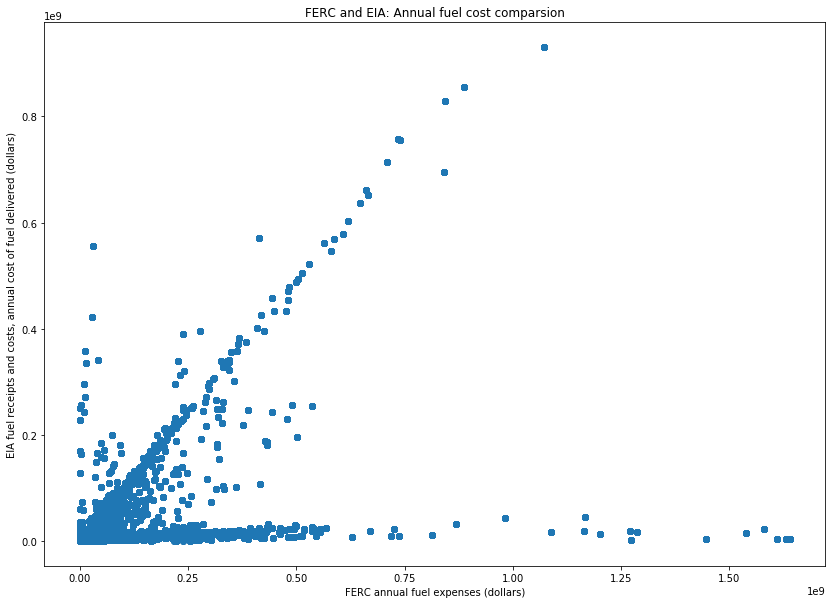

In [26]:
plt.figure(figsize=(14,10))
plt.scatter(merged_df.ferc_fuel_sums,merged_df.annual_fuel_cost)
plt.xlabel('FERC annual fuel expenses (dollars)')
plt.ylabel('EIA fuel receipts and costs, annual cost of fuel delivered (dollars)')
plt.title('FERC and EIA: Annual fuel cost comparsion')

In [28]:
merged_df.corr()

,respondent_id,report_year,expns_fuel,plant_id_pudl,ferc_fuel_sums,plant_id,fuel_quantity,fuel_cost,total_fuel_cost,year,annual_fuel_cost
respondent_id,1.000000,0.059025,-0.228392,0.093753,-0.201092,0.016831,-0.041172,0.002848,-0.049044,0.059025,-0.031087
report_year,0.059025,1.000000,-0.050650,-0.036055,-0.054655,0.077858,0.050704,0.007233,0.025131,1.000000,0.025568
expns_fuel,-0.228392,-0.050650,1.000000,-0.104590,0.538017,-0.046966,0.107676,-0.004147,0.121742,-0.050650,0.208126
plant_id_pudl,0.093753,-0.036055,-0.104590,1.000000,-0.071671,0.050520,-0.004591,-0.001947,-0.000173,-0.036055,0.051446
ferc_fuel_sums,-0.201092,-0.054655,0.538017,-0.071671,1.000000,-0.096331,0.013726,-0.005706,0.026443,-0.054655,0.050615
plant_id,0.016831,0.077858,-0.046966,0.050520,-0.096331,1.000000,0.124804,0.021639,0.100875,0.077858,0.116067
fuel_quantity,-0.041172,0.050704,0.107676,-0.004591,0.013726,0.124804,1.000000,-0.002442,0.956076,0.050704,0.610192
fuel_cost,0.002848,0.007233,-0.004147,-0.001947,-0.005706,0.021639,-0.002442,1.000000,-0.000779,0.007233,0.002248
total_fuel_cost,-0.049044,0.025131,0.121742,-0.000173,0.026443,0.100875,0.956076,-0.000779,1.000000,0.025131,0.641891
year,0.059025,1.000000,-0.050650,-0.036055,-0.054655,0.077858,0.050704,0.007233,0.025131,1.000000,0.025568
